In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re

from PIL import Image, ImageEnhance
import cv2

pd.set_option('display.max_rows', 500)

In [311]:
accumulate_metrics = []

In [ ]:
# root_dir = r"E:\Nextstep\MLChallenge\DeHaDo_AI"
root_dir = r"F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI"
file = 'Inference_test_trocr_large.csv'

In [ ]:
# model_res_path = root_dir + "/" + r"tokenwise-dehado-ai\results\OCR_Results"
model_res_path = root_dir + "/" + r"tokenwise-dehado-ai\results\TrOCR_Results"
df_pred = pd.read_csv(model_res_path + "/" + file)

In [ ]:
label_file = root_dir + "/" + r"results\OCR_Results\test.csv"
df_act = pd.read_csv(label_file)

# Preprocessing

In [ ]:
df_act['folder'] = df_act['image'].apply(lambda x: x.split("/")[2])
df_act['file'] = df_act['image'].apply(lambda x: x.split("/")[-1].replace(".jpg", ""))
df_act.drop('image', axis=1, inplace=True)
df_act.head()

In [ ]:
df_pred.drop('Unnamed: 0', axis=1, inplace=True)

In [160]:
df_pred.rename(columns={'text': 'pred_text'}, inplace=True)
df_pred.head()

,folder,file,pred_text
0,MIT_290,nationality,Indian .
1,MIT_290,Dateofbirth,3/6 ( 1972 .
2,MIT_290,Fatherhusbandname,Bahadurjit Aggarwal
3,MIT_290,permanentaddress,"H.NO. 18 , LOYAL CURCLE , JALANDHAR-309"
4,MIT_290,experience,7 . YEARS AT TALWAR-SHA .


# Combine Label and Predictions

In [ ]:
df_comb = pd.merge(df_pred, df_act, on = ['folder', 'file'], how='left')

In [ ]:
df_comb.rename(columns={'text': 'actual_text'}, inplace=True)
df_comb.head()


In [ ]:
df_comb.to_csv('Combined_Inference_Large.csv')

# EDA on Labels

- Special character distibution by field
- Distribution of special characters across field

In [ ]:
d_special = {}
def count_special_characters(data):
    cnt = 0
    for char in data:
        if char in string.punctuation:
            cnt += 1
            if char in d_special:
                d_special[char] += 1
            else:
                d_special[char] = 1
    return cnt            

In [ ]:
df_comb['n_special'] = df_comb['actual_text'].apply(count_special_characters)

In [ ]:
res = df_comb.groupby('file')['n_special'].sum()
res[res>0].sort_values(ascending=False).plot(kind='bar')

In [ ]:
d_special

### Inference:
- Only 6 different special characters are present with '&' being neglegible

In [ ]:
def count_special_character(data, s_chr):
    cnt = 0
    if 
    for char in data:
        if char in string.punctuation:
            cnt += 1
            if char in d_special:
                d_special[char] += 1
            else:
                d_special[char] = 1
    return cnt   

In [ ]:
df_comb['n_hipen'] = df_comb['actual_text'].apply(lambda x: x.count('-'))
df_comb['n_dot'] = df_comb['actual_text'].apply(lambda x: x.count('.'))
df_comb['n_comma'] = df_comb['actual_text'].apply(lambda x: x.count(','))
df_comb['n_plus'] = df_comb['actual_text'].apply(lambda x: x.count('+'))
df_comb['n_slash'] = df_comb['actual_text'].apply(lambda x: x.count('/'))
df_comb.head()

In [ ]:
df_comb[df_comb['n_special'] > 0].groupby('file').sum()

# Compute Metrics

In [ ]:
df_comb_base = pd.read_csv(r"E:\Nextstep\MLChallenge\DeHaDo_AI\Results\OCR\Combined_Inference_Base.csv")
df_comb_base.head()

In [ ]:
compute_cer_wer(df_comb_base['pred_text'], df_comb_base['actual_text'])

In [ ]:
print("CER: ", char_error_rate(df_comb_base['actual_text'], df_comb_base['pred_text']))
print("WER: ", word_error_rate(df_comb_base['actual_text'], df_comb_base['pred_text']))

In [ ]:
import time
import psutil
import numpy as np

# --- METRICS & EFFICIENCY ---
def levenshtein_distance(s1, s2):
    if isinstance(s1, str):
        s1 = list(s1)
    if isinstance(s2, str):
        s2 = list(s2)
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def word_error_rate(y_true, y_pred):
    total_words = 0
    total_errors = 0
    for t, p in zip(y_true, y_pred):
        t_words = t.split()
        p_words = p.split()
        total_words += len(t_words)
        total_errors += levenshtein_distance(t_words, p_words)
    return total_errors / total_words if total_words > 0 else 0.0

def char_error_rate(y_true, y_pred):
    total_chars = 0
    total_errors = 0
    for t, p in zip(y_true, y_pred):
        total_chars += len(t)
        total_errors += levenshtein_distance(t, p)
    return total_errors / total_chars if total_chars > 0 else 0.0

def field_accuracy(y_true, y_pred):
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_true, y_pred)

def document_level_accuracy(y_true, y_pred, doc_ids):
    from collections import defaultdict
    doc_true = defaultdict(list)
    doc_pred = defaultdict(list)
    for doc_id, t, p in zip(doc_ids, y_true, y_pred):
        doc_true[doc_id].append(t)
        doc_pred[doc_id].append(p)
    correct_docs = 0
    for doc_id in doc_true:
        if doc_true[doc_id] == doc_pred[doc_id]:
            correct_docs += 1
    return correct_docs / len(doc_true) if doc_true else 0.0


In [318]:
word_error_rate('Muthu Kumar asdf', 'muthu Kumar')

0.1

In [ ]:
char_error_rate(df_comb[df_comb['file'] == 'Dateofbirth']['actual_text'], df_comb[df_comb['file'] == 'Dateofbirth']['pred_text'])

In [ ]:
field_list = df_comb['file'].unique()
cer = {}
wer = {}
for field in field_list:
    # print(field)
    predictions = df_comb[df_comb['file'] == field]['pred_text']
    actual = df_comb[df_comb['file'] == field]['actual_text']
    cer[field] = char_error_rate(actual, predictions)
    wer[field] = word_error_rate(actual, predictions)

In [ ]:
metrics_large = pd.DataFrame(cer.values(), columns=['cer'], index = cer.keys())
metrics_large['wer'] = wer
metrics_large

In [ ]:
df_processed = df_comb.copy()
df_processed['processed_text'] = df_processed['pred_text']

In [ ]:
def remove_special_char(text):
    cleaned_text = re.sub(r'[^A-Za-z0-9]+', '', text)
    return cleaned_text

In [ ]:
def numeric_only(text):
    cleaned_text = re.sub(r'[^0-9]+', '', text)
    return cleaned_text

In [ ]:
def char_space(text):
    cleaned_text = re.sub(r'[^A-Za-z ]+', '', text)
    return cleaned_text.strip()

In [237]:
lang_specific("Tamil, Englsh, Hdi")

'Tamil, English, Hindi'

In [236]:
def lang_specific(text, camelcase=True):
    text = re.sub(r'[^A-Za-z ,]+', '', text)
    text = re.sub(r'^[^A-Za-z0-9]+|[^A-Za-z0-9]+$', '', text) # Remove special character at start and end
    text = re.sub(r'[^A-Za-z0-9, ]+', ',', text) # Remove single special character to comma
    text = re.sub(r'\s+,', ',', text) # Remove extra spaces before comma
    words = []
    for word in text.split():
        if camelcase:
            capital_letters = sum(1 for char in text if char.isupper())
            if capital_letters <= len(word)//2:
                # word = word.strip().lower()
                word = word.capitalize().strip()
            else:
                word = word.strip()
        else:
            word = word.strip()
        word = autocorrect_words(word.replace(",",""), 'language') + ","
        words.append(word)
    return " ".join(words)[:-1]

In [352]:
def date_format(text):
    elements = text.split("/")
    corrected = []
    if len(elements) == 3:
        corrected = [str(int(ele)) for ele in elements]
        return "/".join(corrected)
    else:
        return text

In [350]:
date_format("01/09/2024")

['01', '09', '2024']


'1/9/2024'

In [343]:
def date_specific(text):
#     text = text.replace('(', '/').replace(')', '/') # Slash is mis represented as ( by model
    cleaned_text = re.sub(r'[^0-9]+', '/', text)
    cleaned_text = re.sub(r'/+', '/', cleaned_text)
    cleaned_text = re.sub(r'^[^0-9]+|[^0-9]+$', '', cleaned_text)
    cleaned_text = date_format(cleaned_text)
#     cleaned_text = re.sub(r'[^0-9\-/]+', '', text)
    return cleaned_text

In [ ]:
def bloodgroup_specific(text):
    cleaned_text = re.sub(r'[^ABOTabot0-1+\-]+', '', text)
    cleaned_text = cleaned_text.replace('t', '+').replace('0', 'O')
    return cleaned_text.upper().strip()

In [ ]:
def generic(text):
    cleaned_text = re.sub(r'[^A-Za-z0-9 +\-]+', '', text)
    return cleaned_text.strip()

In [265]:
with open("field_vocabulary.json", "r") as f:
    field_vocab = json.load(f)

In [284]:
def autocorrect_words(text, field):
    accept_flag = False
    if field in field_vocab:
        training_labels = field_vocab[field]
        dist = [levenshtein_distance(text, ele) for ele in training_labels]
        
        min_dist, min_dist_ind = np.min(dist), np.argmin(dist)
        corrected = training_labels[min_dist_ind]
        if ((min_dist <= 1) or (min_dist <= 2 and len(corrected) > 4) or (min_dist <= 3 and len(corrected) > 8)) and dist.count(min_dist) <= 1:
            return corrected
        else:
            return text
    else:
        return text

In [ ]:
def process_words2(text):
    words = []
    for word in text.split():
        word = word.capitalize().strip()
        word = autocorrect_words(word, field)
        words.append(word)
    return " ".join(words)

In [ ]:
def alphabets_only(text):
    cleaned_text = re.sub(r'[^A-Za-z]+', '', text)
    return cleaned_text.capitalize()

In [ ]:
def process_words(text, camelcase=False):
    words = []
    for word in text.split():
        if camelcase:
            capital_letters = sum(1 for char in text if char.isupper())
            if capital_letters <= len(word)//2:
                # word = word.strip().lower()
                word = word.capitalize()
            else:
                word = word.strip()
        else:
            word = word.strip()
        words.append(word)
    return " ".join(words)

In [ ]:
def alphanum_specialchar(text):
    cleaned_text = re.sub(r'[^A-Za-z0-9 +\-/,.]+', '', text)
    return cleaned_text.strip()

In [301]:
def address_specific(text):
    text = re.sub(r'^[^A-Za-z0-9]+|[^A-Za-z0-9]+$', '', text) # Remove special character at start and end
    text = re.sub(r'[^A-Za-z0-9, /\-.]+', ',', text) # Remove single special character to comma
    text = re.sub(r'\s+,', ',', text) # Remove extra spaces before comma
    return text

In [103]:
alphatonum = {"o": "0", "O": "0", "b": "6", "z": "2", "Z": "2", "B": "8", "G": "6", "I": "1", "T":"7"}
numtoalpha = {val: key for key, val in alphatonum.items()}
schartonum = {"/": "1", "\\": "1", "(": "1"}


def alpha2num(text):
    text_transform = ""
    for char in text:
        if char.isalpha():
            if char in alphatonum:
                text_transform += alphatonum[char]
            else:
                text_transform += char
        else:
            text_transform += char
    return text_transform

def num2alpha(text):
    text_transform = ""
    for char in text:
        if char.isdigit():
            if char in numtoalpha:
                text_transform += numtoalpha[char]
            else:
                text_transform += char
        else:
            text_transform += char
    return text_transform

def special2num(text):
    text_transform = ""
    for char in text:
        if not char.isalnum():
            if char in schartonum:
                text_transform += schartonum[char]
            else:
                text_transform += char
        else:
            text_transform += char
    return text_transform

In [78]:
def pan_specific(text):
    text = remove_special_char(text)
    text_transform = ""
    if len(text) == 10:
        text_transform = num2alpha(text[:5])
        text_transform += alpha2num(text[5:-1])
        text_transform += num2alpha(text[-1])
    else:
        text_transform = text
    
    return text_transform.upper()

In [344]:
def post_processing(data):
    if data[0] in ['Dateofbirth', 'date']:
        return date_specific(data[1])
    elif data[0] in ['nationality', 'gender', 'maritalstatus']:
        clean_text = alphabets_only(data[1])
        return autocorrect_words(clean_text, data[0])    
    elif data[0] in ['candidatename', 'Fatherhusbandname']:
        clean_text = char_space(data[1])
        return process_words(clean_text, True)
    elif data[0] in ['place']:
        clean_text = alphabets_only(data[1])
#         clean_text = process_words(clean_text, True)
        return autocorrect_words(clean_text, data[0])
    elif data[0] in ['contactnumber', 'AlternateNo', 'aadhaarcard']:
        clean_text = special2num(alpha2num(data[1]))
        return numeric_only(clean_text)
    elif data[0] in ['permanentaddress', 'presentaddress']:
        clean_text = alphanum_specialchar(data[1])
        clean_text = address_specific(clean_text)
        return process_words(clean_text, True)
    elif data[0] in ['bloodgroup']:
        return bloodgroup_specific(data[1])
    elif data[0] in ['experience', 'experience1']:
        clean_text = generic(data[1])
        return process_words(clean_text, False)
    elif data[0] in ['qualification']:
        clean_text = generic(data[1])
        clean_text = process_words(clean_text, True)        
        return autocorrect_words(clean_text, data[0]) 
    elif data[0] in ['referencescmob1', 'referencescmob2']:
        clean_text = reference_specific(data[1])
        return clean_text
    elif data[0] in ['pancard']:
        return pan_specific(data[1])
    elif data[0] in ['languageknown']:
        return lang_specific(data[1])
    else:
        return ""

In [331]:
df_processed_backup = df_processed.copy()

In [353]:
df_processed['processed_text'] = df_processed[['file', 'pred_text']].apply(post_processing, axis=1)


In [354]:
char_error_rate(df_processed['actual_text'], df_processed['processed_text'])

0.1470288108730107

In [355]:
word_error_rate(df_processed['actual_text'], df_processed['processed_text'])

0.4161368959418766

In [329]:
df_test = df_processed[(df_processed['file'] != 'date') & (df_processed['file'] != 'Dateofbirth')]
char_error_rate(df_test['actual_text'], df_test['processed_text']), word_error_rate(df_test['actual_text'], df_test['processed_text'])

(0.14177324283977408, 0.4051517571884984)

In [356]:
df_processed['field_acc_pred'] = df_processed['pred_text'] == df_processed['actual_text']
df_processed['field_acc_processed'] = df_processed['processed_text'] == df_processed['actual_text']

# Metrics

- CER and WER between predicted and processed texts

In [256]:
def final_score(data):
    cer_score = (100 - (data[0] * 100)) * 0.35
    wer_score = (100 - (data[1] * 100)) * 0.35
    field_score = data[2] * 15
    return cer_score + wer_score + field_score

In [257]:
data = [0.059, 0.099, 0.9]
final_score(data)

77.97

In [357]:
cer = {}
wer = {}
f_acc = {}
for field in field_list:
    df_temp = df_processed[df_processed['file']==field]
    cer[field] = [char_error_rate(df_temp['actual_text'], df_temp['pred_text']), char_error_rate(df_temp['actual_text'], df_temp['processed_text'])]
    wer[field] = [word_error_rate(df_temp['actual_text'], df_temp['pred_text']), word_error_rate(df_temp['actual_text'], df_temp['processed_text'])]
    f_acc[field] = [field_accuracy(df_temp['actual_text'], df_temp['pred_text']), field_accuracy(df_temp['actual_text'], df_temp['processed_text'])]
cer['All'] = [char_error_rate(df_processed['actual_text'], df_processed['pred_text']), char_error_rate(df_processed['actual_text'], df_processed['processed_text'])]
wer['All'] = [word_error_rate(df_processed['actual_text'], df_processed['pred_text']), word_error_rate(df_processed['actual_text'], df_processed['processed_text'])]
f_acc['All'] = [field_accuracy(df_processed['actual_text'], df_processed['pred_text']), field_accuracy(df_processed['actual_text'], df_processed['processed_text'])]

cer_df = pd.DataFrame.from_dict(cer, orient='index', columns = ['cer_pred', 'cer_processed'])
wer_df = pd.DataFrame.from_dict(wer, orient='index', columns = ['wer_pred', 'wer_processed'])
facc_df = pd.DataFrame.from_dict(f_acc, orient='index', columns = ['facc_pred', 'facc_processed'])
metrics_df = pd.concat([cer_df, wer_df, facc_df], axis=1)

metrics_df['final_score_pred'] = metrics_df[['cer_pred', 'wer_pred', 'facc_pred']].apply(final_score, axis=1)
metrics_df['final_score_processed'] = metrics_df[['cer_processed', 'wer_processed', 'facc_processed']].apply(final_score, axis=1)                                                                                     
metrics_df    

,cer_pred,cer_processed,wer_pred,wer_processed,facc_pred,facc_processed,final_score_pred,final_score_processed
nationality,0.304676,0.059578,0.852941,0.099548,0.352941,0.900452,34.777526,77.937406
Dateofbirth,0.687696,0.220082,3.839644,0.659243,0.004454,0.340757,-88.390060,44.334997
Fatherhusbandname,0.252202,0.113788,0.830000,0.388889,0.082222,0.404444,33.356262,58.472992
permanentaddress,0.310923,0.251514,1.300696,0.758701,0.000000,0.031111,13.593322,35.109166
experience,0.176803,0.145936,0.422158,0.341845,0.051111,0.144444,49.803012,55.094341
date,0.824570,0.240295,4.268182,0.668182,0.000000,0.331818,-108.246314,43.180590
presentaddress,0.315119,0.253325,1.297668,0.737997,0.000000,0.033333,13.552447,35.803722
gender,0.459750,0.008497,1.328090,0.015730,0.031461,0.984270,7.897530,83.916077
bloodgroup,0.976954,0.135271,1.578231,0.290249,0.074830,0.709751,-18.309033,65.753059
experience1,0.187324,0.152242,0.454582,0.365784,0.035556,0.124444,48.066600,53.735743


In [358]:
accumulate_metrics.append(metrics_df.loc['All'])
accumulate_metrics

[cer_pred                  0.298689
 cer_processed             0.147535
 wer_pred                  1.154677
 wer_processed             0.422160
 facc_pred                 0.055235
 facc_processed            0.469949
 final_score_pred         19.960696
 final_score_processed    57.109912
 Name: All, dtype: float64,
 cer_pred                  0.298689
 cer_processed             0.147861
 wer_pred                  1.154677
 wer_processed             0.422016
 facc_pred                 0.055235
 facc_processed            0.470289
 final_score_pred         19.960696
 final_score_processed    57.108626
 Name: All, dtype: float64,
 cer_pred                  0.298689
 cer_processed             0.147029
 wer_pred                  1.154677
 wer_processed             0.416137
 facc_pred                 0.055235
 facc_processed            0.484211
 final_score_pred         19.960696
 final_score_processed    57.552358
 Name: All, dtype: float64]

In [ ]:
metrics_df.to_csv("metrics_test_set.csv")

In [250]:
1.85*0.35 + (0.9*0.15)

0.7825

In [247]:
df_processed[df_processed['file'] == 'place']['actual_text'].unique()

array(['Patna', 'Ranchi', 'Hyderabad', 'Bengaluru', 'Gangtok',
       'Gandhinagar', 'Chandigarh', 'Thiruvananthapuram', 'Mumbai',
       'Kavaratti', 'Bhopal', 'Dehradun', 'Kohima', 'Delhi', 'Lucknow',
       'Shillong', 'Raipur', 'Chennai', 'Dispur', 'Kolkata', 'Panaji',
       'Agartala', 'Aizawl', 'Imphal', 'Itanagar', 'Jaipur', 'Shimla'],
      dtype=object)

# WER Analysis

# Field Metric Analysis

### Language Analysis

In [233]:
field_name = 'languageknown'
df_processed[(df_processed['field_acc_processed'] == False) & (df_processed['file'] == field_name)]

,folder,file,pred_text,actual_text,processed_text,field_acc_pred,field_acc_processed
11,MIT_290,languageknown,"Tamil , English , Malayalam , Gusarati","Tamil, Malayalam, English, Gujarati",Tamil English Malayalam Gujarati,False,False
31,MIT_207,languageknown,"Tamil , Marathi , Kannada , Gujarati","Tamil, Marathi, Kannada, Gujarati",Tamil Marathi Kannada Gujarati,False,False
51,MIT_484,languageknown,"English , Tamil .","English, Tamil",English Tamil,False,False
72,MIT_101,languageknown,"Tamil , Kannada","Tamil, Kannada",Tamil Kannada,False,False
92,VIT_778,languageknown,"Malayalam , English , Hindi , Tamil","Malayalam, English, Hindi, Tamil",Malayalam English Hindi Tamil,False,False
113,MIT_587,languageknown,"Kannada , Hindi , Malayalam","Kannada, Hindi, Malayalam",Kannada Hindi Malayalam,False,False
133,MIT_52,languageknown,English . Telugu .,"English, Telugu",English Telugu,False,False
153,MIT_482,languageknown,"Telugu , Tamil .","Telugu, Tamil",Telugu Tamil,False,False
173,MIT_565,languageknown,"Hindi , English","Hindi, English",Hindi English,False,False
193,TCE_1368,languageknown,"Tarnil , English , trade .","Tamil, English, Hindi","Tarnil, English Trade",False,False


### Place Analysis

In [291]:
field_name = 'place'
df_processed[(df_processed['field_acc_processed'] == False) & (df_processed['file'] == field_name)]

,folder,file,pred_text,actual_text,processed_text,field_acc_pred,field_acc_processed
139,MIT_52,place,Orkendhinagar .,Gandhinagar,Orkendhinagar,False,False
275,TCE_1390,place,Dehraelum .,Dehradun,Dehraelum,False,False
466,VIT_921,place,( Weignovo .,Lucknow,Weignovo,False,False
780,MIT_431,place,Isonima .,Kohima,Isonima,False,False
999,MIT_662,place,Gavarok,Gangtok,Gavarok,False,False
1156,TCE_1129,place,Ipanna,Patna,Ipanna,False,False
1234,VIT_795,place,bramatoke,Gangtok,Bramatoke,False,False
1607,MIT_323,place,dulenow .,Lucknow,Dulenow,False,False
1647,MIT_424,place,against a cantala .,Agartala,Againstacantala,False,False
1725,TCE_1357,place,Impoka ) .,Imphal,Impoka,False,False


### Permanent Analysis

In [313]:
field_name = 'permanentaddress'
df_processed[(df_processed['field_acc_processed'] == False) & (df_processed['file'] == field_name)]

,folder,file,pred_text,actual_text,processed_text,field_acc_pred,field_acc_processed
3,MIT_290,permanentaddress,"H.NO. 18 , LOYAL CURCLE , JALANDHAR-309","H.No. 18, Loyal Circle, Jalandhar 309001","H.NO. 18, LOYAL CURCLE, JALANDHAR-309",False,False
23,MIT_207,permanentaddress,"H.No. 57 , Pandit Nagor : Thoothukudi 148026","H.No. 57, Pandit Nagar, Thoothukudi 148026","H.No. 57, Pandit Nagor Thoothukudi 148026",False,False
43,MIT_484,permanentaddress,"H.NO. 148 , Sampath , Begugorai -3","H.No. 148, Sampath, Begusarai-826493","H.NO. 148, Sampath, Begugorai -3",False,False
64,MIT_101,permanentaddress,"84187 , Dholiwal , Granette mayor - 4.28.39","84/87, Dhaliwal, Gandhinagar-420439","84187, Dholiwal, Granette Mayor - 4.28.39",False,False
84,VIT_778,permanentaddress,"22/42 , Taylor Path , Hospet-774575 .","22/42, Tailor Path, Hospet-774575","22/42, Taylor Path, Hospet-774575",False,False
105,MIT_587,permanentaddress,"H. No. 52 , Bhakta , Nagpur -600011","H.No. 52, Bhakta, Nagpur-600011","H. No. 52, Bhakta, Nagpur -600011",False,False
125,MIT_52,permanentaddress,"H. No. ie. Dhalinal Path , Aungaon","H.No. 12, Dhaliwal Path, Gurgaon 966278","H. No. ie. Dhalinal Path, Aungaon",False,False
145,MIT_482,permanentaddress,"26,655 , Bhodti , Morbi 253809 .","26/655, Bhatti, Morbi 253809","26,655, Bhodti, Morbi 253809",False,False
165,MIT_565,permanentaddress,"87/8b , Hole Nagour , Berhampur-213170","87/86, Gole Nagar, Berhampur-213170","87/8b, Hole Nagour, Berhampur-213170",False,False
185,TCE_1368,permanentaddress,"594 , Dhalimal Zila , Bangalore-567453","594, Dhaliwal Zila, Bangalore-567453","594, Dhalimal Zila, Bangalore-567453",False,False


### References

In [ ]:
field_name = 'referencescmob1'
df_processed[(df_processed['field_acc_processed'] == False) & (df_processed['file'] == field_name)]

In [ ]:
field_name = 'referencescmob1'
len(df_processed[(df_processed['field_acc_processed'] == False) & (df_processed['file'] == field_name)])

### Date/DOB

In [339]:
field_name = 'date'
df_processed[(df_processed['field_acc_processed'] == False) & (df_processed['file'] == field_name)][['folder','pred_text','actual_text','processed_text']]

,folder,pred_text,actual_text,processed_text
5,MIT_290,12/05 ( 2025 .,12-05-2025,12/05/2025
25,MIT_207,4/20 (2023 .,11/20/2023,4/20/2023
45,MIT_484,01 ( 14 ) 2022 .,1/14/2022,01/14/2022
86,VIT_778,to3/90 (2022 .,3/30/2022,3/90/2022
107,MIT_587,or lobby 2022,07-06-2022,2022
127,MIT_52,or (29 ( 2025 .,7/29/2025,29/2025
147,MIT_482,03 ( 29 ( 2025 .,3/29/2025,03/29/2025
167,MIT_565,09 04 ( 2023 .,09-04-2023,09/04/2023
187,TCE_1368,orfirst 2023 .,7/11/2023,2023
206,TCE_1047,"04 (071,2003 .",4/7/2023,04/071/2003


In [341]:
df_processed[df_processed['file'] =='date']['actual_text'].str.split("/")

5         [12-05-2025]
25      [11, 20, 2023]
45       [1, 14, 2022]
66      [12, 19, 2024]
86       [3, 30, 2022]
107       [07-06-2022]
127      [7, 29, 2025]
147      [3, 29, 2025]
167       [09-04-2023]
187      [7, 11, 2023]
206       [4, 7, 2023]
225     [10, 19, 2025]
245     [11, 23, 2024]
264      [1, 31, 2022]
283     [12, 18, 2024]
302      [2, 20, 2023]
320      [8, 11, 2025]
339      [12, 4, 2024]
358      [8, 26, 2023]
378       [1, 3, 2024]
397      [9, 15, 2024]
416      [1, 14, 2022]
435       [10-03-2025]
454      [8, 23, 2023]
474      [1, 23, 2022]
494       [10-02-2025]
514       [02-02-2023]
534      [1, 11, 2023]
553     [11, 17, 2022]
572      [2, 19, 2025]
593      [7, 13, 2025]
614      [9, 29, 2024]
633       [10-08-2025]
653       [8, 2, 2025]
672      [9, 15, 2023]
691       [04-12-2022]
710      [9, 17, 2023]
730     [12, 20, 2022]
749     [12, 26, 2025]
768      [1, 15, 2024]
788     [11, 27, 2024]
808       [1, 6, 2024]
828     [12, 21, 2023]
848      [1

In [ ]:
sorted(df_processed[(df_processed['actual_text'].str.contains("-")) & (df_processed['file'] == 'Dateofbirth')]['folder'])

In [320]:
"07116".split("1")

['07', '', '6']

### Pancard

In [338]:
field_name = 'pancard'
df_processed[(df_processed['field_acc_processed'] == False) & (df_processed['file'] == field_name)]

,folder,file,pred_text,actual_text,processed_text,field_acc_pred,field_acc_processed
54,MIT_484,pancard,XIXS GO 726m.,XJXSG0726G,XIXSG0726M,False,False
95,VIT_778,pancard,VOX DB450P .,VOXDB4550P,VOXDB450P,False,False
796,MIT_35,pancard,HDE VHTO 7OOL,HDEVH6706L,HDEVHTO7OOL,False,False
836,MIT_385,pancard,ADOST 24 6H.,ADOST2463H,ADOST246H,False,False
915,MIT_174,pancard,VCJRH14937 .,VCJRH1493J,VCJRH1493T,False,False
974,MIT_488,pancard,Qumzh 374dn,QUMZH3740N,QUMZH374DN,False,False
1135,MIT_163,pancard,( BRUCIDOQV .,CBRUC1009V,BRUCIDOQV,False,False
1230,VIT_795,pancard,EPKKA3162Z ...,EPKKA3126Z,EPKKA3162Z,False,False
1447,MIT_142,pancard,TO I Q G.obby,JOIQG6906Y,TOIQGOBBY,False,False
1525,MIT_570,pancard,cehehisist .,CEHEH1313T,CEHEHISIST,False,False


In [87]:
df_processed[(df_processed['field_acc_processed'] == False) & (df_processed['file'] == field_name)].count()

folder                 62
file                   62
pred_text              62
actual_text            62
processed_text         62
field_acc_pred         62
field_acc_processed    62
dtype: int64

### Aadharcard

In [94]:
field_name = 'aadhaarcard'
df_processed[(df_processed['field_acc_processed'] == False) & (df_processed['file'] == field_name)]

,folder,file,pred_text,actual_text,processed_text,field_acc_pred,field_acc_processed
32,MIT_207,aadhaarcard,6058350000000,606000000000.0,6058350000000,False,False
52,MIT_484,aadhaarcard,151 68 1000000,751687000000,151681000000,False,False
73,MIT_101,aadhaarcard,502211800000,502000000000.0,502211800000,False,False
93,VIT_778,aadhaarcard,7874lbs000000 .0,787000000000.0,78740000000,False,False
114,MIT_587,aadhaarcard,b57.39200000,657000000000.0,5739200000,False,False
134,MIT_52,aadhaarcard,48 (583000000,482000000000.0,48583000000,False,False
174,MIT_565,aadhaarcard,"81 336,00000",813000000000.0,8133600000,False,False
232,MIT_233,aadhaarcard,223696000000,224000000000.0,223696000000,False,False
404,MIT_200,aadhaarcard,295208000000 .,295000000000.0,295208000000,False,False
441,MIT_110,aadhaarcard,"8k 44,680000bp .",864000000000.0,844680000,False,False


In [92]:
df_processed[(df_processed['field_acc_processed'] == False) & (df_processed['file'] == field_name)].count()

folder                 200
file                   200
pred_text              200
actual_text            200
processed_text         200
field_acc_pred         200
field_acc_processed    200
dtype: int64

### Contact Number

In [363]:
384/16

24.0

In [95]:
field_name = 'contactnumber'
print(df_processed[(df_processed['field_acc_processed'] == False) & (df_processed['file'] == field_name)].count())
df_processed[(df_processed['field_acc_processed'] == False) & (df_processed['file'] == field_name)]

folder                 233
file                   233
pred_text              233
actual_text            233
processed_text         233
field_acc_pred         233
field_acc_processed    233
dtype: int64


,folder,file,pred_text,actual_text,processed_text,field_acc_pred,field_acc_processed
15,MIT_290,contactnumber,99 28 524 27 .,9928524127,992852427,False,False
76,MIT_101,contactnumber,"9253 54,3 1 .",9253640631,92535431,False,False
117,MIT_587,contactnumber,8965IM0584 .,8965170584,89650584,False,False
137,MIT_52,contactnumber,9251995/15 .,9251995115,925199515,False,False
177,MIT_565,contactnumber,7713 4.8750 .,7713428750,771348750,False,False
254,TCE_1073,contactnumber,860-77bbbb36 .,8607766636,8607736,False,False
273,TCE_1390,contactnumber,207772976 ) .,7177219761,207772976,False,False
292,TCE_1039,contactnumber,9.89655359,9789655354,989655359,False,False
329,TCE_1266,contactnumber,82.5.2.2.237 .,8252492237,82522237,False,False
348,TCE_1174,contactnumber,94 68 68155,9468681555,946868155,False,False


### Qualification

In [109]:
field_name = 'qualification'
print(df_processed[(df_processed['field_acc_processed'] == False) & (df_processed['file'] == field_name)].count())
df_processed[(df_processed['field_acc_processed'] == False) & (df_processed['file'] == field_name)]

folder                 257
file                   257
pred_text              257
actual_text            257
processed_text         257
field_acc_pred         257
field_acc_processed    257
dtype: int64


,folder,file,pred_text,actual_text,processed_text,field_acc_pred,field_acc_processed
10,MIT_290,qualification,10th pass .,10th Pass,10th pass,False,False
112,MIT_587,qualification,Ph D .,PhD,Ph D,False,False
152,MIT_482,qualification,12th pass .,12th Pass,12th pass,False,False
172,MIT_565,qualification,10th pass .,10th Pass,10th pass,False,False
192,TCE_1368,qualification,diploma .,Diploma,diploma,False,False
250,TCE_1073,qualification,post-graduate .,Post-Graduate,post-graduate,False,False
269,TCE_1390,qualification,cloth pass .,10th Pass,cloth pass,False,False
288,TCE_1039,qualification,diploma .,Diploma,diploma,False,False
344,TCE_1174,qualification,12th pass .,12th Pass,12th pass,False,False
363,MIT_274,qualification,Diplomat .,Diploma,Diplomat,False,False


In [ ]:
keys = list(cer.keys())
val1 = [cer[k][0] for k in keys]
val2 = [cer[k][1] for k in keys]
x = np.arange(len(keys))  # Positions for keys
width = 0.35  # Width of each bar

plt.figure(figsize=(10, 4))
plt.bar(x - width/2, val1, width, label='Predicted')
plt.bar(x + width/2, val2, width, label='Processed')
plt.xticks(x, keys, rotation=90)
plt.title('CER')
plt.legend()
plt.show()

In [ ]:
keys = list(wer.keys())
val1 = [wer[k][0] for k in keys]
val2 = [wer[k][1] for k in keys]
x = np.arange(len(keys))  # Positions for keys
width = 0.35  # Width of each bar

plt.figure(figsize=(10, 4))
plt.bar(x - width/2, val1, width, label='Predicted')
plt.bar(x + width/2, val2, width, label='Processed')
plt.xticks(x, keys, rotation=90)
plt.title('WER')
plt.legend()
plt.show()

### CER/WER Analysis
- CER: Blood Group
- WER: perm/present Address, DOB/Date, Blood Group, language known, 

## Blood Group Analysis

In [ ]:
field = 'bloodgroup'
df_temp = df_processed[df_processed['file'] == field]
print(df_temp[df_temp['actual_text'] != df_temp['processed_text']][['pred_text','actual_text','processed_text']])

## Language Group Analysis

In [ ]:
pd.set_option('display.max_rows', None)
field = 'languageknown'
df_temp = df_processed[df_processed['file'] == field]
print("CER: ", char_error_rate(df_temp['actual_text'], df_temp['processed_text']))
print("WER: ", word_error_rate(df_temp['actual_text'], df_temp['processed_text']))
df_temp[df_temp['actual_text'] != df_temp['processed_text']][['pred_text','actual_text','processed_text']]

# Permanent Address

In [ ]:
pd.set_option('display.max_rows', None)
field = 'permanentaddress'
df_temp = df_processed[df_processed['file'] == field]
print("CER: ", char_error_rate(df_temp['actual_text'], df_temp['processed_text']))
print("WER: ", word_error_rate(df_temp['actual_text'], df_temp['processed_text']))
df_temp[df_temp['actual_text'] != df_temp['processed_text']][['pred_text','actual_text','processed_text']]

In [ ]:
len(df_temp[df_temp['actual_text'] != df_temp['processed_text']][['pred_text','actual_text','processed_text']])

# Date Analysis

In [ ]:
pd.set_option('display.max_rows', None)
field = 'date'
df_temp = df_processed[df_processed['file'] == field]
print("CER: ", char_error_rate(df_temp['actual_text'], df_temp['processed_text']))
print("WER: ", word_error_rate(df_temp['actual_text'], df_temp['processed_text']))
df_temp[df_temp['actual_text'] != df_temp['processed_text']][['pred_text','actual_text','processed_text']]

In [ ]:
len(df_temp[df_temp['actual_text'] != df_temp['processed_text']][['pred_text','actual_text','processed_text']])

In [ ]:
field_name = 'Dateofbirth'
df_temp = df_processed[df_processed['file'] == field_name]
df_processed.loc[df_processed['file'] == field_name, 'processed_text'] = df_processed[['file', 'pred_text']].apply(post_processing, axis=1)
df_processed
# df_processed[df_processed['file'] == 'nationality'][['pred_text', 'processed_text']]
# char_error_rate(df_processed[df_processed['file'] == field_name]['actual_text'], df_processed[df_processed['file'] == field_name]['processed_text'])

In [ ]:
field_name = 'Dateofbirth'
df_processed.loc[df_processed['file'] == field_name, 'processed_text'] =  df_processed[df_processed['file'] == field_name]['pred_text'].apply(date_specific)
# df_processed[df_processed['file'] == 'nationality'][['pred_text', 'processed_text']]
char_error_rate(df_processed[df_processed['file'] == field_name]['actual_text'], df_processed[df_processed['file'] == field_name]['processed_text'])

In [ ]:
field_name = 'date'
df_processed.loc[df_processed['file'] == field_name, 'processed_text'] =  df_processed[df_processed['file'] == field_name]['pred_text'].apply(date_specific)
# df_processed[df_processed['file'] == 'nationality'][['pred_text', 'processed_text']]
char_error_rate(df_processed[df_processed['file'] == field_name]['actual_text'], df_processed[df_processed['file'] == field_name]['processed_text'])

In [ ]:
field_name = 'bloodgroup'
df_processed.loc[df_processed['file'] == field_name, 'processed_text'] =  df_processed[df_processed['file'] == field_name]['pred_text'].apply(bloodgroup_specific)
# df_processed[df_processed['file'] == 'nationality'][['pred_text', 'processed_text']]
char_error_rate(df_processed[df_processed['file'] == field_name]['actual_text'], df_processed[df_processed['file'] == field_name]['processed_text'])

## Nationality

In [ ]:
df_processed.loc[df_processed['file'] == field_name, 'processed_text'] =  df_processed[df_processed['file'] == 'nationality']['pred_text'].apply(remove_special_char)
df_processed[df_processed['file'] == 'nationality'][['pred_text', 'processed_text']]
char_error_rate(df_processed[df_processed['file'] == 'nationality']['actual_text'], df_processed[df_processed['file'] == 'nationality']['processed_text'])

In [ ]:
field_name = 'pancard'
df_processed.loc[df_processed['file'] == field_name, 'processed_text'] =  df_processed[df_processed['file'] == field_name]['pred_text'].apply(remove_special_char)
# df_processed[df_processed['file'] == 'nationality'][['pred_text', 'processed_text']]
char_error_rate(df_processed[df_processed['file'] == field_name]['actual_text'], df_processed[df_processed['file'] == field_name]['processed_text'])

In [ ]:
field_name = 'maritalstatus'
df_processed.loc[df_processed['file'] == field_name, 'processed_text'] =  df_processed[df_processed['file'] == field_name]['pred_text'].apply(remove_special_char)
# df_processed[df_processed['file'] == 'nationality'][['pred_text', 'processed_text']]
char_error_rate(df_processed[df_processed['file'] == field_name]['actual_text'], df_processed[df_processed['file'] == field_name]['processed_text'])

In [ ]:
field_name = 'gender'
df_processed.loc[df_processed['file'] == field_name, 'processed_text'] =  df_processed[df_processed['file'] == field_name]['pred_text'].apply(remove_special_char)
# df_processed[df_processed['file'] == 'nationality'][['pred_text', 'processed_text']]
char_error_rate(df_processed[df_processed['file'] == field_name]['actual_text'], df_processed[df_processed['file'] == field_name]['processed_text'])

In [ ]:
field_name = 'contactnumber'
df_processed.loc[df_processed['file'] == field_name, 'processed_text'] =  df_processed[df_processed['file'] == field_name]['pred_text'].apply(numeric_only)
df_processed[df_processed['file'] == field_name][['pred_text', 'processed_text']]
char_error_rate(df_processed[df_processed['file'] == field_name]['actual_text'], df_processed[df_processed['file'] == field_name]['processed_text'])  

In [ ]:
field_name = 'AlternateNo'
df_processed.loc[df_processed['file'] == field_name, 'processed_text'] =  df_processed[df_processed['file'] == field_name]['pred_text'].apply(numeric_only)
df_processed[df_processed['file'] == field_name][['pred_text', 'processed_text']]
char_error_rate(df_processed[df_processed['file'] == field_name]['actual_text'], df_processed[df_processed['file'] == field_name]['processed_text'])  

In [ ]:
field_name = 'aadhaarcard'
df_processed.loc[df_processed['file'] == field_name, 'processed_text'] =  df_processed[df_processed['file'] == field_name]['pred_text'].apply(numeric_only)
df_processed[df_processed['file'] == field_name][['pred_text', 'processed_text']]
char_error_rate(df_processed[df_processed['file'] == field_name]['actual_text'], df_processed[df_processed['file'] == field_name]['processed_text'])  

In [ ]:
field_name = 'candidatename'
df_processed.loc[df_processed['file'] == field_name, 'processed_text'] =  df_processed[df_processed['file'] == field_name]['pred_text'].apply(char_space)
df_processed[df_processed['file'] == field_name][['pred_text', 'processed_text']]
char_error_rate(df_processed[df_processed['file'] == field_name]['actual_text'], df_processed[df_processed['file'] == field_name]['processed_text'])  

In [ ]:
field_name = 'Fatherhusbandname'
df_processed.loc[df_processed['file'] == field_name, 'processed_text'] = df_processed[df_processed['file'] == field_name]['pred_text'].apply(char_space)
df_processed[df_processed['file'] == field_name][['pred_text', 'processed_text']]
char_error_rate(df_processed[df_processed['file'] == field_name]['actual_text'], df_processed[df_processed['file'] == field_name]['processed_text'])  

In [ ]:
field_name = 'place'
df_processed.loc[df_processed['file'] == field_name, 'processed_text'] = df_processed[df_processed['file'] == field_name]['pred_text'].apply(char_space)
df_processed[df_processed['file'] == field_name][['pred_text', 'processed_text']]
char_error_rate(df_processed[df_processed['file'] == field_name]['actual_text'], df_processed[df_processed['file'] == field_name]['processed_text'])  

In [ ]:
char_error_rate(df_processed['actual_text'], df_processed['pred_text'])

In [ ]:
word_error_rate(df_processed['actual_text'], df_processed['pred_text'])

In [ ]:
char_error_rate(df_processed['actual_text'], df_processed['processed_text'])

In [ ]:
word_error_rate(df_processed['actual_text'], df_processed['processed_text'])

In [ ]:
# No. of words
# Date: 
# Only numeric
# Only Alpha numeric
# 

# Anand OCR Model Results Analysis

In [140]:
import jellyfish
noisy_word = "sngl"
valid_labels = ['Single', 'Married']
similarities = [jellyfish.jaro_winkler_similarity(noisy_word.lower(), label.lower()) for label in valid_labels]
max_index = similarities.index(max(similarities))
valid_labels[max_index], max(similarities)

('Single', 0.8999999999999999)

In [142]:
df_temp = df_processed[df_processed['file'] == 'maritalstatus'][['pred_text', 'actual_text', 'processed_text']].copy()

In [155]:
def find_distance(texts):
    return [levenshtein_distance('Single', texts[1]), levenshtein_distance('Married', texts[1]), levenshtein_distance('UnMarried', texts[1])]

In [152]:
valid_labels = ['Single', 'Married']
def find_wink_similarity(texts):
    noisy_word = texts[1]
    similarities = [jellyfish.jaro_winkler_similarity(noisy_word.lower(), label.lower()) for label in valid_labels]
    max_index = similarities.index(max(similarities))
#     valid_labels[max_index], max(similarities)
    return max(similarities)

In [156]:
df_temp['l_dist'] = df_temp[['actual_text', 'processed_text']].apply(find_distance, axis=1)

In [153]:
df_temp['wink_sim'] = df_temp['processed_text'].apply(find_wink_similarity)

In [159]:
df_temp[df_temp['actual_text'] != df_temp['processed_text']]

,pred_text,actual_text,processed_text,l_dist,wink_sim
136,Mounied .,Married,Mounied,"[6, 3, 5]",0.000000
156,I married,Married,Imarried,"[7, 2, 3]",0.742857
291,manned .,Married,Manned,"[5, 3, 5]",0.714286
347,turn old .,Single,Turnold,"[5, 5, 7]",0.000000
367,I married,Married,Imarried,"[7, 2, 3]",0.742857
443,Sing live .,Single,Singlive,"[2, 7, 8]",0.722222
503,Niaquied .,Married,Niaquied,"[6, 4, 5]",0.722222
561,Marneed .,Married,Marneed,"[6, 2, 4]",0.714286
680,I Marnied .,Married,Imarnied,"[7, 3, 4]",0.742857
738,Mazzied .,Married,Mazzied,"[6, 2, 4]",0.714286


In [161]:
label_file = root_dir + "/" + r"Dataset\temp\train.csv"
df_act_train = pd.read_csv(label_file)

df_act_train['folder'] = df_act_train['image'].apply(lambda x: x.split("/")[2])
df_act_train['file'] = df_act_train['image'].apply(lambda x: x.split("/")[-1].replace(".jpg", ""))
df_act_train.drop('image', axis=1, inplace=True)
df_act_train.head()

,text,folder,file
0,Dayita Bakshi,MIT_1,candidatename
1,Laksh Bakshi,MIT_1,Fatherhusbandname
2,12/27/1975,MIT_1,Dateofbirth
3,Post-Graduate,MIT_1,qualification
4,Married,MIT_1,maritalstatus


In [162]:
gender_labels = df_act_train[df_act_train['file'] == 'gender']['text'].unique()
gender_labels

array(['Female', 'Male'], dtype=object)

In [163]:
marital_labels = df_act_train[df_act_train['file'] == 'maritalstatus']['text'].unique()
marital_labels

array(['Married', 'Single'], dtype=object)

In [164]:
qualification_labels = df_act_train[df_act_train['file'] == 'qualification']['text'].unique()
qualification_labels

array(['Post-Graduate', 'Graduate', 'Diploma', '10th Pass', '12th Pass',
       'PhD', 'Integrated M.tech', 'B.Tech'], dtype=object)

In [166]:
nationality_labels = df_act_train[df_act_train['file'] == 'nationality']['text'].unique()
nationality_labels

array(['Indian'], dtype=object)

In [176]:
language = df_act_train[df_act_train['file'] == 'languageknown']['text']
lang_labels = []
for i in range(len(language)):
    text = language.iloc[i]
    text = re.sub(r"[^A-Za-z0-9 ]+", "", text)
#     text = [ele.strip() for ele in text.split()]
    for ele in text.split():
        ele = ele.strip()
        if ele not in lang_labels:
            lang_labels.append(ele)
lang_labels

['Marathi',
 'English',
 'Telugu',
 'Hindi',
 'Bengali',
 'Kannada',
 'Malayalam',
 'Gujarati',
 'Tamil',
 'Kanada']

In [260]:
place_labels = df_act_train[df_act_train['file'] == 'place']['text'].unique()
place_labels

array(['Dehradun', 'Bhopal', 'Itanagar', 'Kolkata', 'Jaipur',
       'Gandhinagar', 'Imphal', 'Panaji', 'Shillong', 'Lucknow', 'Dispur',
       'Thiruvananthapuram', 'Patna', 'Agartala', 'Gangtok', 'Kohima',
       'Chennai', 'Chandigarh', 'Shimla', 'Ranchi', 'Kavaratti', 'Mumbai',
       'Aizawl', 'Hyderabad', 'Raipur', 'Delhi', 'Bengaluru', 'Nellore',
       'koilkuntla', 'Ternekal'], dtype=object)

In [263]:
field_vocabulary = {}
field_vocabulary['gender'] = list(gender_labels)
field_vocabulary['maritalstatus'] = list(marital_labels)
field_vocabulary['nationality'] = list(nationality_labels)
field_vocabulary['qualification'] = list(qualification_labels)
field_vocabulary['language'] = lang_labels
field_vocabulary['place'] = list(place_labels)
field_vocabulary


{'gender': ['Female', 'Male'],
 'maritalstatus': ['Married', 'Single'],
 'nationality': ['Indian'],
 'qualification': ['Post-Graduate',
  'Graduate',
  'Diploma',
  '10th Pass',
  '12th Pass',
  'PhD',
  'Integrated M.tech',
  'B.Tech'],
 'language': ['Marathi',
  'English',
  'Telugu',
  'Hindi',
  'Bengali',
  'Kannada',
  'Malayalam',
  'Gujarati',
  'Tamil',
  'Kanada'],
 'place': ['Dehradun',
  'Bhopal',
  'Itanagar',
  'Kolkata',
  'Jaipur',
  'Gandhinagar',
  'Imphal',
  'Panaji',
  'Shillong',
  'Lucknow',
  'Dispur',
  'Thiruvananthapuram',
  'Patna',
  'Agartala',
  'Gangtok',
  'Kohima',
  'Chennai',
  'Chandigarh',
  'Shimla',
  'Ranchi',
  'Kavaratti',
  'Mumbai',
  'Aizawl',
  'Hyderabad',
  'Raipur',
  'Delhi',
  'Bengaluru',
  'Nellore',
  'koilkuntla',
  'Ternekal']}

In [264]:
import json
with open("field_vocabulary.json", "w") as f:
    json.dump(field_vocabulary, f)

# Load the dictionary from the JSON file


# Centroid Matching

In [395]:
import os
label_json = r"F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\labels"
d = []
for file in os.listdir(label_json):
    file_path = label_json + "/" + file
    field, coord = load_gt(file_path, ret_fields=False)
    d.append({f: c for f, c in zip(field, coord)})

In [396]:
d

[{'candidatename': [914, 384, 1550, 485],
  'Father/husbandname': [949, 484, 1617, 583],
  'Dateofbirth': [969, 586, 1513, 677],
  'qualification': [973, 682, 1678, 774],
  'maritalstatus': [936, 785, 1325, 882],
  'gender': [1817, 775, 2143, 871],
  'nationality': [1885, 886, 2226, 977],
  'bloodgroup': [973, 890, 1142, 980],
  'experience': [1065, 987, 2008, 1092],
  'experience1': [1062, 1096, 2184, 1201],
  'presentaddress': [919, 1238, 2293, 1442],
  'permanentaddress': [912, 1483, 2382, 1637],
  'AlternateNo': [1750, 1795, 2313, 1883],
  'contactnumber': [919, 1758, 1389, 1874],
  'languageknown': [919, 1889, 2203, 1991],
  'referencescmob1': [993, 1999, 2261, 2108],
  'referencescmob2': [1024, 2120, 2345, 2241],
  'aadhaarcard': [627, 2332, 1284, 2421],
  'place': [630, 2427, 1048, 2511],
  'date': [637, 2515, 1103, 2611]},
 {'candidatename': [898, 388, 1315, 474],
  'Father/husbandname': [910, 487, 1322, 572],
  'Dateofbirth': [920, 586, 1220, 666],
  'qualification': [933, 682

In [430]:
data = pd.DataFrame(d)
data.head()

,candidatename,Father/husbandname,Dateofbirth,qualification,maritalstatus,gender,nationality,bloodgroup,experience,experience1,...,permanentaddress,AlternateNo,contactnumber,languageknown,referencescmob1,referencescmob2,aadhaarcard,place,date,pancard
0,"[914, 384, 1550, 485]","[949, 484, 1617, 583]","[969, 586, 1513, 677]","[973, 682, 1678, 774]","[936, 785, 1325, 882]","[1817, 775, 2143, 871]","[1885, 886, 2226, 977]","[973, 890, 1142, 980]","[1065, 987, 2008, 1092]","[1062, 1096, 2184, 1201]",...,"[912, 1483, 2382, 1637]","[1750, 1795, 2313, 1883]","[919, 1758, 1389, 1874]","[919, 1889, 2203, 1991]","[993, 1999, 2261, 2108]","[1024, 2120, 2345, 2241]","[627, 2332, 1284, 2421]","[630, 2427, 1048, 2511]","[637, 2515, 1103, 2611]",NaN
1,"[898, 388, 1315, 474]","[910, 487, 1322, 572]","[920, 586, 1220, 666]","[933, 682, 1215, 764]","[941, 781, 1153, 869]","[1821, 774, 2029, 863]","[1847, 884, 2049, 969]","[944, 887, 1073, 968]","[976, 980, 1685, 1083]","[909, 1092, 2216, 1201]",...,"[891, 1496, 2211, 1643]","[1847, 1739, 2261, 1835]","[908, 1746, 1249, 1843]","[928, 1887, 1447, 1979]","[982, 1993, 1896, 2104]","[978, 2124, 1871, 2226]","[638, 2326, 1085, 2404]","[706, 2418, 925, 2501]","[685, 2513, 1043, 2593]",NaN
2,"[895, 423, 1413, 530]","[894, 527, 1528, 632]","[904, 631, 1376, 729]","[878, 727, 1205, 833]","[895, 831, 1214, 930]","[1808, 818, 2108, 924]","[1853, 933, 2136, 1029]","[920, 932, 1132, 1025]","[955, 1029, 2103, 1137]","[1009, 1142, 2098, 1258]",...,"[877, 1533, 2228, 1785]","[1627, 1846, 2222, 1943]","[871, 1798, 1361, 1927]","[869, 1941, 2230, 2050]","[929, 2048, 2279, 2184]","[962, 2184, 2091, 2315]",NaN,"[597, 2468, 1003, 2562]","[608, 2563, 1093, 2679]","[1630, 2385, 2191, 2489]"
3,"[873, 430, 1496, 532]","[860, 530, 1614, 637]","[888, 630, 1305, 721]","[882, 727, 1226, 824]","[901, 833, 1271, 935]","[1786, 828, 2168, 928]","[1847, 939, 2212, 1035]","[924, 937, 1071, 1026]","[983, 1040, 2453, 1151]","[952, 1145, 2434, 1261]",...,"[894, 1520, 2344, 1692]","[1842, 1799, 2344, 1910]","[869, 1796, 1355, 1903]","[881, 1933, 1543, 2039]","[957, 2034, 2189, 2157]","[936, 2176, 2258, 2296]",NaN,"[573, 2470, 965, 2560]","[591, 2566, 1021, 2670]","[1611, 2384, 2178, 2477]"
4,"[922, 431, 1502, 528]","[922, 530, 1544, 638]","[916, 635, 1329, 736]","[908, 739, 1286, 833]","[901, 836, 1219, 932]","[1834, 824, 2076, 913]","[1914, 927, 2224, 1031]","[917, 941, 1051, 1031]","[1008, 1038, 2347, 1145]","[988, 1145, 2365, 1262]",...,"[889, 1525, 2389, 1653]","[1868, 1802, 2333, 1927]","[884, 1807, 1363, 1932]","[880, 1945, 2297, 2052]","[956, 2052, 2284, 2165]","[958, 2178, 2237, 2305]","[611, 2385, 1215, 2478]","[607, 2478, 919, 2578]","[624, 2566, 1141, 2674]",NaN


In [561]:
def load_gt(gt_file_path, ret_fields=False):
    with open(gt_file_path, 'r') as f:
        data = json.load(f)
    coordinates = [d['Coordinate'] for d in data]
    fields = [remove_special_char(d['Field name']) for d in data]
    return fields, coordinates

In [431]:
data['candidatename'] = data['candidatename'].dropna()

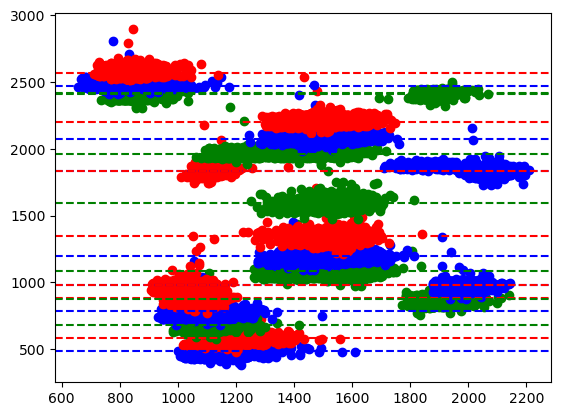

In [442]:
col_list = list(data.columns)
color = ['b', 'r', 'g']
cat = 0
median = []
for j, col in enumerate(col_list):
    x = []
    y = []
    
    for i in range(len(data)):
        coord = data[col].iloc[i]
        try:
            x.append((coord[0]+coord[2])/2)
            y.append((coord[1]+coord[3])/2)
        except:
            pass
    
    plt.scatter(x, y, color=color[cat])
    median.append(np.median(y))
    plt.axhline(y=np.median(y), color=color[cat], linestyle='--')
    cat += 1
    if cat > 2:
        cat = 0

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, 'candidatename'),
  Text(1, 0, 'Father/husbandname'),
  Text(2, 0, 'Dateofbirth'),
  Text(3, 0, 'qualification'),
  Text(4, 0, 'maritalstatus'),
  Text(5, 0, 'gender'),
  Text(6, 0, 'nationality'),
  Text(7, 0, 'bloodgroup'),
  Text(8, 0, 'experience'),
  Text(9, 0, 'experience1'),
  Text(10, 0, 'presentaddress'),
  Text(11, 0, 'permanentaddress'),
  Text(12, 0, 'AlternateNo'),
  Text(13, 0, 'contactnumber'),
  Text(14, 0, 'languageknown'),
  Text(15, 0, 'referencescmob1'),
  Text(16, 0, 'referencescmob2'),
  Text(17, 0, 'aadhaarcard'),
  Text(18, 0, 'place'),
  Text(19, 0, 'date'),
  Text(20, 0, 'pancard')])

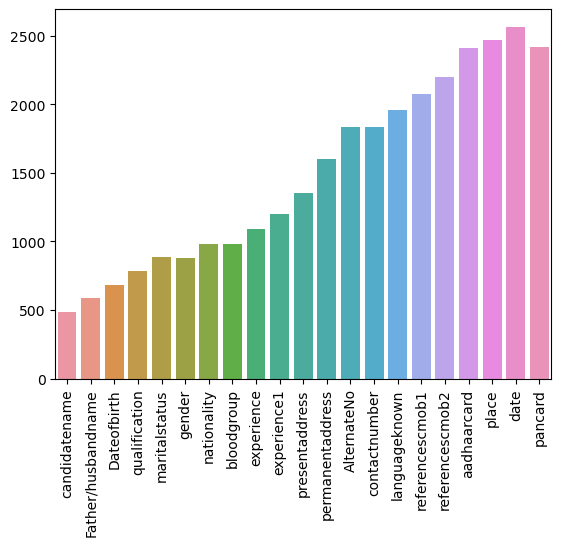

In [446]:
import seaborn as sns
sns.barplot(y = median, x= col_list)
plt.xticks(rotation=90)

In [450]:
file_name = "VIT_888.jpg"
image_path = r"F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\tokenwise-dehado-ai\data\data1\train\images"

In [724]:
def get_table_coordinates(image_path):
    image = Image.open(image_path)
    enhancer = ImageEnhance.Contrast(image)
    contrast_image = enhancer.enhance(2)  # 1

    opencv_image = np.array(contrast_image)

    # Convert RGB to BGR
    opencv_image = cv2.cvtColor(opencv_image, cv2.COLOR_RGB2BGR)

    # Convert BGR to GRAY
    gray_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2GRAY)

    # Apply Blurr on Image
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Apply Canny Edge Detection
    edged = cv2.Canny(blurred_image, 150, 200)

    # Find contours
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours on the original image
    cv2.drawContours(opencv_image, contours, -1, (0, 255, 0), 2) # Green color, thickness 2
#     plt.imshow(opencv_image)
    # Calculate Contour Area
    area = []
    for cont in contours:
        bbox_coord = cv2.boundingRect(cont)
#         x1, x2, y1, y2 = x, x + w, y, y + h
        area.append(bbox_coord[2] * bbox_coord[3])

    
    # Get Coordinates of Max Contour Area    
    cnt = contours[np.argmax(area)]
    x, y, w, h = cv2.boundingRect(cnt)
    x1, x2, y1, y2 = x, x + w, y, y + h
    return [x1, y1, x2, y2]#, contours

# Load Reference

In [661]:
ref_df = pd.read_excel(r"F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\tokenwise-dehado-ai\assets\Ref_Coordinates.xlsx")
ref_df.set_index('Field', inplace=True)

In [532]:
def norm_coordinates(table_coord, field_coord):
    cell_x1, cell_y1, cell_x2, cell_y2 = field_coord
    table_x1, table_y1, table_x2, table_y2 = table_coord
    
    table_width = table_x2 - table_x1
    table_height = table_y2 - table_y1
    
    norm_x1 = (cell_x1 - table_x1) / table_width
    norm_y1 = (cell_y1 - table_y1) / table_height
    norm_x2 = (cell_x2 - table_x1) / table_width
    norm_y2 = (cell_y2 - table_y1) / table_height
    
    return [np.round(norm_x1, 4), np.round(norm_y1, 4), np.round(norm_x2, 4), np.round(norm_y2, 4)]

In [605]:
def centroid(coord):
    return np.round((coord[0] + coord[2])/2,4), np.round((coord[1] + coord[3])/2, 4)

def distance(centroid1, centroid2):
    return np.round((centroid1[0] - centroid2[0]) ** 2, 6) , np.round((centroid1[1] - centroid2[1]) ** 2, 6)

In [625]:
def load_ref_coordinates(file_path):
    ref_df = pd.read_excel(file_path)
    ref_df.set_index('Field', inplace=True)
    ref_table_coordinates = list(ref_df.loc['Full'])[:-2]
    ref_centroids = {}
    ref_columns = list(ref_df.index)
    for ind in range(1, len(ref_columns)):
        f_coordinates = list(ref_df.loc[ref_columns[ind]])[:-2]        
#         ref_centroids[ref_columns[ind]] = centroid(norm_coordinates(ref_table_coordinates, f_coordinates))
        ref_centroids[ref_columns[ind]] = norm_coordinates(ref_table_coordinates, f_coordinates)
    return ref_centroids

In [730]:
def find_matches(table_coordinates, field_coordinates):
    pred_field = []
    for cent in field_coordinates:
        min_dist = {}
        for key, val in table_coordinates.items():
            min_dist[key] = compute_iou(cent, val)
        pred_field.append(max(min_dist, key = lambda x: min_dist[x]))
    
    return pred_field

In [ ]:
def compute_iou(boxA, boxB):
    # Unpack coordinates
    xA_min, yA_min, xA_max, yA_max = boxA
    xB_min, yB_min, xB_max, yB_max = boxB

    # Compute intersection coordinates
    x_left = max(xA_min, xB_min)
    y_top = max(yA_min, yB_min)
    x_right = min(xA_max, xB_max)
    y_bottom = min(yA_max, yB_max)

    # Check for no overlap
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Compute intersection area
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Compute areas of each box
    boxA_area = (xA_max - xA_min) * (yA_max - yA_min)
    boxB_area = (xB_max - xB_min) * (yB_max - yB_min)

    # Compute IoU
    iou = intersection_area / float(boxA_area + boxB_area - intersection_area)
    return iou

In [737]:
ref_table_coordinates = load_ref_coordinates(r"F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\tokenwise-dehado-ai\assets\Ref_Coordinates.xlsx")

In [731]:
image_path = root_dir + "/" + r"Dataset\test\images"
labels_path = root_dir + "/" + r"Dataset\test\labels"
res_df = pd.DataFrame(columns=['File', 'Coordinates', 'Pred', 'Actual'])
for file in os.listdir(image_path):
    filename = file.split(".")[0]
    label_file = filename + ".json"
    print("Running ", filename, " ...")
    local_table_coordinates = get_table_coordinates(image_path +  "/" + file)
    fields, coords = load_gt(labels_path + "/" + label_file)
    field_coordinates = []
    for coord in coords:
        field_coordinates.append(norm_coordinates(local_table_coordinates, coord))
    pred_fields = find_matches(ref_table_coordinates, field_coordinates)
    
    data = {'File': [filename] * len(pred_fields), 'Coordinates': coords, 'Pred': pred_fields, 'Actual': fields}
    res_df = pd.concat([res_df, pd.DataFrame(data)])
    

Running  MIT_10  ...
Running  MIT_101  ...
Running  MIT_106  ...
Running  MIT_109  ...
Running  MIT_11  ...
Running  MIT_110  ...
Running  MIT_111  ...
Running  MIT_117  ...
Running  MIT_119  ...
Running  MIT_120  ...
Running  MIT_121  ...
Running  MIT_122  ...
Running  MIT_128  ...
Running  MIT_129  ...
Running  MIT_13  ...
Running  MIT_131  ...
Running  MIT_133  ...
Running  MIT_135  ...
Running  MIT_142  ...
Running  MIT_145  ...
Running  MIT_147  ...
Running  MIT_148  ...
Running  MIT_151  ...
Running  MIT_155  ...
Running  MIT_16  ...
Running  MIT_162  ...
Running  MIT_163  ...
Running  MIT_165  ...
Running  MIT_167  ...
Running  MIT_169  ...
Running  MIT_173  ...
Running  MIT_174  ...
Running  MIT_177  ...
Running  MIT_18  ...
Running  MIT_183  ...
Running  MIT_185  ...
Running  MIT_186  ...
Running  MIT_187  ...
Running  MIT_19  ...
Running  MIT_191  ...
Running  MIT_194  ...
Running  MIT_196  ...
Running  MIT_199  ...
Running  MIT_2  ...
Running  MIT_20  ...
Running  MIT_200  .

Running  VIT_732  ...
Running  VIT_734  ...
Running  VIT_737  ...
Running  VIT_739  ...
Running  VIT_741  ...
Running  VIT_744  ...
Running  VIT_752  ...
Running  VIT_753  ...
Running  VIT_755  ...
Running  VIT_764  ...
Running  VIT_765  ...
Running  VIT_766  ...
Running  VIT_768  ...
Running  VIT_769  ...
Running  VIT_770  ...
Running  VIT_771  ...
Running  VIT_772  ...
Running  VIT_773  ...
Running  VIT_774  ...
Running  VIT_776  ...
Running  VIT_778  ...
Running  VIT_782  ...
Running  VIT_784  ...
Running  VIT_786  ...
Running  VIT_790  ...
Running  VIT_792  ...
Running  VIT_795  ...
Running  VIT_799  ...
Running  VIT_804  ...
Running  VIT_808  ...
Running  VIT_811  ...
Running  VIT_814  ...
Running  VIT_817  ...
Running  VIT_818  ...
Running  VIT_829  ...
Running  VIT_839  ...
Running  VIT_842  ...
Running  VIT_843  ...
Running  VIT_852  ...
Running  VIT_853  ...
Running  VIT_861  ...
Running  VIT_865  ...
Running  VIT_866  ...
Running  VIT_867  ...
Running  VIT_868  ...
Running  V

In [733]:
res_df_backup = res_df.copy()

In [732]:
failed_res = res_df[res_df['Pred'] != res_df['Actual']]

In [734]:
failed_res.groupby('File')['Pred'].count()

File
MIT_266      1
MIT_428      1
MIT_434      5
MIT_494      1
MIT_529      1
MIT_59       1
TCE_1083     2
TCE_1096     1
TCE_1104     1
TCE_1110     1
TCE_1156     1
TCE_1306     1
TCE_1331    19
TCE_1344     1
TCE_1472     1
VIT_727      1
VIT_811      1
VIT_981      1
Name: Pred, dtype: int64

In [736]:
failed_res

,File,Coordinates,Pred,Actual
13,MIT_266,"[880, 1744, 1873, 1984]",languageknown,contactnumber
3,MIT_428,"[885, 694, 1177, 782]",maritalstatus,qualification
0,MIT_434,"[908, 401, 1502, 501]",Fatherhusbandname,candidatename
1,MIT_434,"[896, 511, 1552, 589]",Dateofbirth,Fatherhusbandname
3,MIT_434,"[929, 718, 1265, 799]",maritalstatus,qualification
11,MIT_434,"[970, 1467, 2261, 1609]",permanentaddress,AlternateNo
13,MIT_434,"[1983, 1690, 2404, 1804]",AlternateNo,permanentaddress
2,MIT_494,"[903, 663, 1259, 844]",Dateofbirth,qualification
18,MIT_529,"[595, 2492, 869, 2589]",aadhaarcard,place
3,MIT_59,"[916, 743, 1327, 840]",maritalstatus,qualification


In [726]:
image_path = root_dir + "/" + r"Dataset\train\images"
labels_path = root_dir + "/" + r"Dataset\train\labels"
res_df = pd.DataFrame(columns=['File', 'Coordinates', 'Pred', 'Actual'])
file = "MIT_102.jpg"
filename = file.split(".")[0]
label_file = filename + ".json"
local_table_coordinates = get_table_coordinates(image_path +  "/" + file)
fields, coords = load_gt(labels_path + "/" + label_file)
field_coordinates = []
for coord in coords:
    field_coordinates.append(norm_coordinates(local_table_coordinates, coord))
pred_fields, min_dist = find_matches(ref_table_coordinates, field_coordinates)

data = {'File': [filename] * len(pred_fields), 'Coordinates': coords, 'Pred': pred_fields, 'Actual': fields}
# res_df = pd.concat([res_df, pd.DataFrame(data)])

In [727]:
[print(p,a) for p, a in zip(data['Pred'], data['Actual'])]

candidatename candidatename
Fatherhusbandname Fatherhusbandname
Dateofbirth Dateofbirth
qualification qualification
maritalstatus maritalstatus
gender gender
nationality nationality
bloodgroup bloodgroup
experience experience
experience1 experience1
presentaddress presentaddress
permanentaddress permanentaddress
AlternateNo AlternateNo
contactnumber contactnumber
languageknown languageknown
referencescmob1 referencescmob1
referencescmob2 referencescmob2
pancard pancard
aadhaarcard place
date date


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [717]:
failed_res[failed_res['File'] == "MIT_104"]

,File,Coordinates,Pred,Actual
1,MIT_104,"[922, 530, 1544, 638]",candidatename,Fatherhusbandname
2,MIT_104,"[916, 635, 1329, 736]",candidatename,Dateofbirth
3,MIT_104,"[908, 739, 1286, 833]",candidatename,qualification
4,MIT_104,"[901, 836, 1219, 932]",candidatename,maritalstatus
5,MIT_104,"[1834, 824, 2076, 913]",candidatename,gender
6,MIT_104,"[1914, 927, 2224, 1031]",candidatename,nationality
7,MIT_104,"[917, 941, 1051, 1031]",candidatename,bloodgroup
8,MIT_104,"[1008, 1038, 2347, 1145]",candidatename,experience
9,MIT_104,"[988, 1145, 2365, 1262]",candidatename,experience1
10,MIT_104,"[914, 1275, 2445, 1415]",candidatename,presentaddress


In [716]:
failed_res.head()

,File,Coordinates,Pred,Actual
18,MIT_102,"[597, 2468, 1003, 2562]",aadhaarcard,place
1,MIT_103,"[860, 530, 1614, 637]",candidatename,Fatherhusbandname
2,MIT_103,"[888, 630, 1305, 721]",candidatename,Dateofbirth
3,MIT_103,"[882, 727, 1226, 824]",candidatename,qualification
4,MIT_103,"[901, 833, 1271, 935]",candidatename,maritalstatus


In [685]:
area = []
for cont in contours:
    area.append(cv2.contourArea(cont))

# Get Coordinates of Max Contour Area    
cnt = contours[np.argmax(area)]

In [688]:
len(cnt)

254

In [696]:
area = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    x1, x2, y1, y2 = x, x + w, y, y + h
    print([x1, y1, x2, y2])
    area.append(w*h)

[727, 3308, 732, 3316]
[2112, 3242, 2117, 3257]
[1904, 3015, 1908, 3018]
[1992, 2991, 1997, 2995]
[652, 2613, 653, 2616]
[722, 2610, 755, 2645]
[643, 2609, 679, 2644]
[753, 2600, 792, 2648]
[606, 2599, 639, 2641]
[667, 2596, 689, 2609]
[564, 2566, 565, 2567]
[194, 2564, 564, 2655]
[195, 2563, 196, 2564]
[86, 2563, 192, 2655]
[874, 2521, 883, 2525]
[654, 2519, 666, 2530]
[876, 2514, 890, 2520]
[785, 2513, 805, 2527]
[620, 2510, 623, 2513]
[592, 2495, 646, 2541]
[697, 2481, 701, 2491]
[700, 2474, 732, 2539]
[195, 2472, 564, 2565]
[86, 2472, 193, 2562]
[566, 2385, 2344, 2660]
[1285, 2384, 1600, 2474]
[566, 2382, 1283, 2474]
[195, 2381, 564, 2471]
[86, 2380, 193, 2470]
[195, 2379, 196, 2380]
[195, 2316, 2344, 2385]
[87, 2316, 193, 2380]
[87, 2314, 88, 2315]
[1183, 2181, 1188, 2183]
[1173, 2177, 1195, 2197]
[867, 2172, 2344, 2320]
[1592, 2082, 1616, 2100]
[1586, 2047, 1608, 2074]
[867, 2042, 2344, 2174]
[867, 2040, 868, 2041]
[195, 2040, 865, 2316]
[87, 2039, 193, 2314]
[867, 1939, 2344, 20

In [699]:
cnt = contours[np.argmax(area)]
x, y, w, h = cv2.boundingRect(cnt)
x, y, x + w, y + h

(83, 332, 2381, 2698)